Reference: https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. Thanks to [Khanh](https://twitter.com/khanhlvg) & [Meghna](https://twitter.com/natrajmeghna) for their help and guidance. The models used here were trained on the Pascal VOC 2012 dataset. 

## Setup

In [4]:
import os
import tempfile
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.9.2


## Inference using TFLite model

### 1. Get Input Image Size

In [5]:
#@title Choose TFLite model type

model_dict = {
    "dynamic-range": "/kaggle/input/mobilenetv2/tflite/coco-dr/1/1.tflite",
    "fp16": "/kaggle/input/mobilenetv2/tflite/coco-fp16/1/1.tflite",
    "int8": "/kaggle/input/mobilenetv2/tflite/coco-int8/1/1.tflite"
}

tflite_model_type = "fp16" # @param ['dynamic-range', 'fp16', 'int8']

# Load the model.
interpreter = tf.lite.Interpreter(model_path=model_dict[tflite_model_type])

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Get image size - converting from BHWC to WH
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

(513, 513)


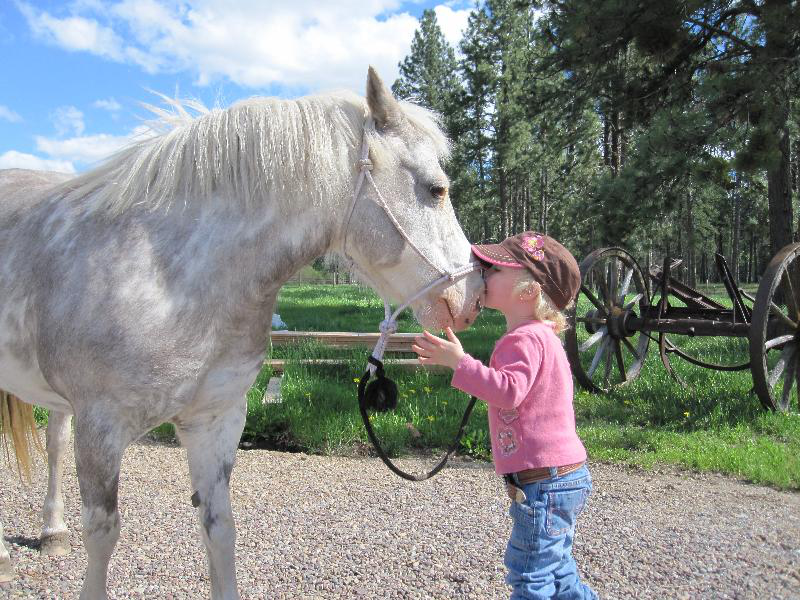

In [18]:

from PIL import Image
image = Image.open('/kaggle/input/imagee/IMG_5346.jpg')
image

#### Prepare the downloaded image for running inference

(600, 600) (800, 600)


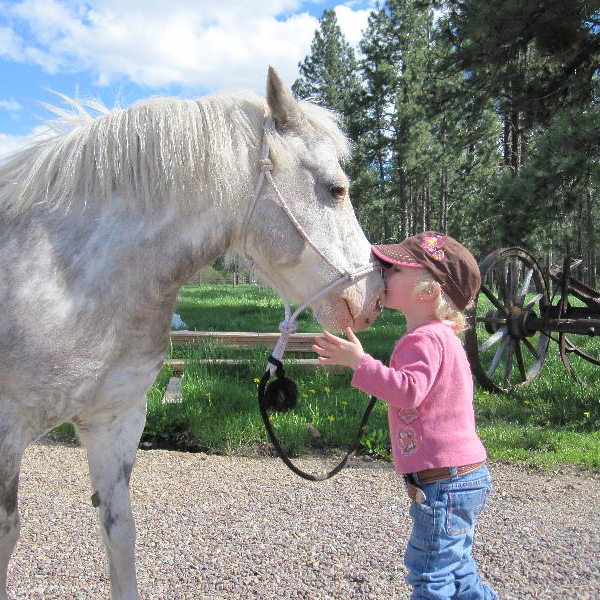

In [19]:
from PIL import ImageOps

old_size = image.size  # old_size is in (width, height) format
desired_ratio = input_size[0] / input_size[1]
old_ratio = old_size[0] / old_size[1]

if old_ratio < desired_ratio: # '<': cropping, '>': padding
    new_size = (old_size[0], int(old_size[0] / desired_ratio))
else:
    new_size = (int(old_size[1] * desired_ratio), old_size[1])

print(new_size, old_size)

# Cropping the original image to the desired aspect ratio
delta_w = new_size[0] - old_size[0]
delta_h = new_size[1] - old_size[1]
padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
cropped_image = ImageOps.expand(image, padding)
cropped_image

In [20]:
# Resize the cropped image to the desired model size
resized_image = cropped_image.convert('RGB').resize(input_size, Image.BILINEAR)

# Convert to a NumPy array, add a batch dimension, and normalize the image.
image_for_prediction = np.asarray(resized_image).astype(np.float32)
image_for_prediction = np.expand_dims(image_for_prediction, 0)
image_for_prediction = image_for_prediction / 127.5 - 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  


Thanks to Khanh for helping to figure out the pre-processing and post-processing code.

### 3. Run Inference

In [21]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path=model_dict[tflite_model_type])

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

# Post-processing: convert raw output to segmentation output
## Method 1: argmax before resize - this is used in some frozen graph
# seg_map = np.squeeze(np.argmax(raw_prediction, axis=3)).astype(np.int8)
# seg_map = np.asarray(Image.fromarray(seg_map).resize(image.size, resample=Image.NEAREST))
## Method 2: resize then argmax - this is used in some other frozen graph and produce smoother output
width, height = cropped_image.size
seg_map = tf.argmax(tf.image.resize(raw_prediction, (height, width)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

The following code comes from https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb. 

In [22]:
#@title
from matplotlib import gridspec
from matplotlib import pyplot as plt

def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

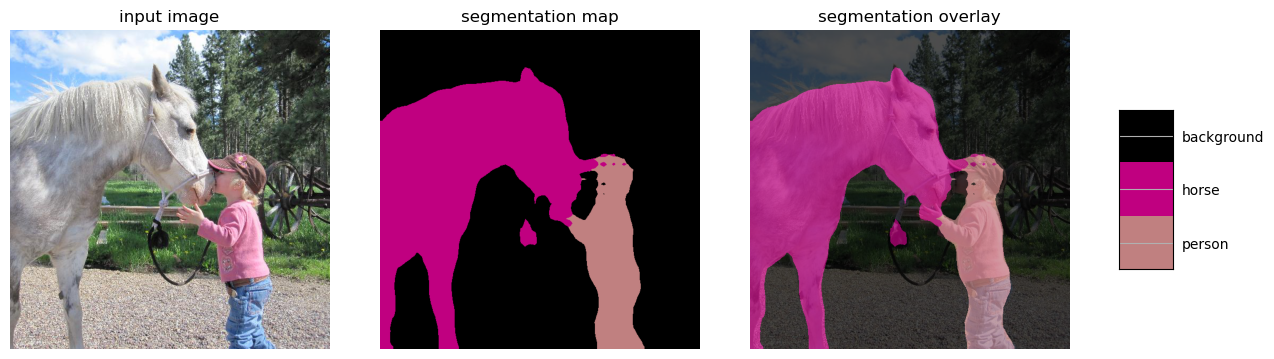

In [23]:
vis_segmentation(cropped_image, seg_map)


To try out a new model it's advisable to Factory Reset the runtime and then trying it.

Credit: https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/DeepLabV3/DeepLab_TFLite_COCO.ipynb